# 🎬 Netflix Data Labeling Lab — Notebook 3: Data Slicing & Model Development

---

### 🧠 **Objective**
This notebook represents the final phase of the Netflix Data Labeling Lab.  
After generating weak supervision labels (Notebook 1) and expanding the dataset through text augmentation (Notebook 2),  
we now focus on **data slicing**, **model training**, and **evaluation**.  
The goal is to build robust machine-learning models that can automatically classify Netflix titles as **family-friendly** or **not family-friendly**,  
evaluate them across diverse data slices, and export reusable model artifacts for downstream applications or dashboards.

---

### ⚙️ **Workflow Overview**
1. **Load Dataset** – Import the augmented dataset (`netflix_augmented.csv`) or fall back to the labeled version.  
2. **Feature Preparation** – Construct text, numeric, and categorical feature blocks for model input.  
3. **Model Pipelines** – Build multiple end-to-end pipelines with TF-IDF + scikit-learn estimators.  
4. **Cross-Validation** – Compare models (Logistic Regression, Random Forest, Calibrated Linear SVC) using ROC-AUC.  
5. **Model Training & Evaluation** – Fit the best models on training data, evaluate on a held-out test split, and visualize ROC / PR curves.  
6. **Data Slicing** – Define interpretable subsets (e.g., Kids, Horror, Long TV Shows) and compute metrics per slice to test fairness and robustness.  
7. **Threshold Tuning** – Adjust classification thresholds for optimal F1-score.  
8. **Model Export** – Save the trained pipeline, threshold, and test predictions.  
9. **Explainability & Dashboard Export** – Display top TF-IDF features for Logistic Regression and export a minimal dataset for visualization tools.

---

### 🧩 **Key Concepts**

#### 🪄 Pipeline Architecture
All preprocessing steps — text vectorization (TF-IDF), numeric scaling, categorical encoding —  
are encapsulated within scikit-learn `Pipeline` and `ColumnTransformer` objects, ensuring fully reproducible model training.

#### 📊 Model Selection
We evaluate three complementary learners:
- **Logistic Regression** — interpretable linear baseline.  
- **Random Forest** — high-variance ensemble capturing nonlinear interactions.  
- **Calibrated Linear SVC** — margin-based classifier with calibrated probabilities.

#### 🧩 Data Slicing
Slicing tests how well models perform on specific content subsets:
- *Kids / Family* genres  
- *Horror / Thriller* titles  
- *Long TV shows* (≥ 3 seasons)  
- *Short Movies* (< 90 minutes)  
- *Titles with kids-related keywords*

This provides a fairness-style breakdown of model behavior across themes.

#### ⚖️ Evaluation Metrics
- **Accuracy** – Overall correctness  
- **ROC AUC** – Ranking quality  
- **PR AUC** – Precision-recall trade-off  
- **F1 Score** – Balance of precision & recall  
- **Per-Slice Metrics** – Localized robustness evaluation  

---

### 🔄 **Outcome**
By the end of this notebook you will have:
- A fully trained and validated model for predicting `is_family_friendly`.  
- Detailed ROC / PR curves and classification metrics.  
- Slice-level performance diagnostics for interpretability.  
- Saved model artifacts (`outputs_best_model.pkl`) and prediction exports (`predictions_test.csv`).  
- A compact dashboard-ready output table with probabilities, predictions, genres, and ratings.



###  Step 1 — Import Libraries and Load the Dataset
We start by importing all the required libraries for data processing, modeling, and evaluation.  
The notebook automatically loads the **augmented dataset** (`netflix_augmented.csv`) produced in Notebook 2; if it’s missing, it falls back to the **labeled dataset** from Notebook 1.  
This ensures reproducibility and consistency across the full pipeline.


In [1]:
# === Notebook 3: Data Slicing & Model Development ===

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib
import matplotlib.pyplot as plt

# --- Paths (edit if needed)
ROOT = "/Users/sreevarshansathiyamurthy/Downloads/netflix_lab"
AUG_PATH = os.path.join(ROOT, "netflix_augmented.csv")
LAB_PATH = os.path.join(ROOT, "netflix_labeled_family.csv")
OUT_MODEL = os.path.join(ROOT, "outputs_best_model.pkl")
OUT_PRED = os.path.join(ROOT, "predictions_test.csv")

# --- Load augmented if available, else labeled
if os.path.exists(AUG_PATH):
    df = pd.read_csv(AUG_PATH)
    print("✅ Loaded augmented dataset:", AUG_PATH, df.shape)
else:
    df = pd.read_csv(LAB_PATH)
    print("✅ Loaded labeled dataset:", LAB_PATH, df.shape)

LABEL_COL = "is_family_friendly"
assert LABEL_COL in df.columns, "Label column not found in dataframe!"


✅ Loaded augmented dataset: /Users/sreevarshansathiyamurthy/Downloads/netflix_lab/netflix_augmented.csv (13083, 19)


### Step 2 — Prepare Features and Split Data
We identify three groups of input features:
- **Text features** – the combined title + description column.  
- **Numeric features** – duration, release year, cast/genre counts.  
- **Categorical features** – type, rating, duration unit.  

The data is then split into **80 % training** and **20 % testing** sets, maintaining label balance with stratification.


In [3]:
# Ensure consistent column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Build a single 'text' column if not present
if "text" not in df.columns:
    df["text"] = (df.get("title", "").fillna("") + " " + df.get("description", "").fillna("")).str.lower()

# Numeric helpers (may be NaN for augmented rows; we'll impute)
num_cols = []
for c in ["duration_num", "num_cast", "num_genres", "release_year"]:
    if c in df.columns:
        num_cols.append(c)

# Categorical helpers
cat_cols = [c for c in ["type", "rating", "duration_unit"] if c in df.columns]

# Feature summary
print("Text col: 'text'")
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Train/test split
X = df
y = df[LABEL_COL].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train.shape, X_test.shape


Text col: 'text'
Numeric cols: ['duration_num', 'release_year']
Categorical cols: ['type', 'rating', 'duration_unit']


((10466, 19), (2617, 19))

###  Step 3 — Build Preprocessing and Model Pipelines
We use `ColumnTransformer` to apply the right preprocessing to each feature type:
- **TF-IDF Vectorizer** on text.  
- **Standard Scaler + Imputer** on numeric columns.  
- **One-Hot Encoder** on categorical columns.  

Three strong models are configured:
1. **Logistic Regression** – linear, interpretable baseline.  
2. **Random Forest** – nonlinear ensemble capturing feature interactions.  
3. **Calibrated Linear SVC** – margin-based classifier with calibrated probabilities for ranking quality.

In [7]:
# Preprocess blocks
text_processor = ("text", TfidfVectorizer(
    max_features=60000,
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
), "text")

num_processor = ("num", Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]), num_cols) if num_cols else None

cat_processor = ("cat", Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
]), cat_cols) if cat_cols else None

# Build ColumnTransformer dynamically
transformers = [text_processor]
if num_processor: transformers.append(num_processor)
if cat_processor: transformers.append(cat_processor)

preprocess = ColumnTransformer(transformers=transformers)

# Two strong baselines
logreg = LogisticRegression(max_iter=3000, n_jobs=None)  # liblinear-like behavior handled internally
rf = RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1)

# Calibrated SVC for better probabilities (robust on sparse TF-IDF)
# --- Calibrated SVC for better probabilities (robust on sparse TF-IDF) ---
from sklearn.svm import LinearSVC

svc = CalibratedClassifierCV(
    estimator=LinearSVC(C=1.0, class_weight="balanced", random_state=42),
    method="isotonic",
    cv=3
)


pipe_lr = Pipeline([("prep", preprocess), ("clf", logreg)])
pipe_rf = Pipeline([("prep", preprocess), ("clf", rf)])
pipe_svc = Pipeline([("prep", preprocess), ("clf", svc)])


###  Step 4 — Evaluate Models via 5-Fold Cross Validation
We use 5-fold stratified cross-validation to compare models on **ROC-AUC**.  
This metric measures how well the classifier ranks family-friendly vs non-family content.  
Each model’s mean ± standard deviation of ROC-AUC gives a reliable estimate of generalization before final training.


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_auc(pipe, X, y):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean(), scores.std()

for name, model in [("LogReg", pipe_lr), ("RandForest", pipe_rf), ("Calib-SVC", pipe_svc)]:
    mean_auc, std_auc = cv_auc(model, X_train, y_train)
    print(f"{name:10s} | ROC AUC (5-fold): {mean_auc:.4f} ± {std_auc:.4f}")


LogReg     | ROC AUC (5-fold): 0.9728 ± 0.0032
RandForest | ROC AUC (5-fold): 0.9977 ± 0.0003


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Calib-SVC  | ROC AUC (5-fold): 0.9854 ± 0.0023


###  Step 5 — Train and Select the Best Model
All three pipelines are fitted on the training data and evaluated on the held-out test split.  
We compute **ROC-AUC** and **PR-AUC** (precision–recall) to identify the most effective model.  
The highest-performing model is then selected as the champion for downstream evaluation and saving.


In [11]:
# Fit on training set
models = [("LogReg", pipe_lr), ("RandForest", pipe_rf), ("Calib-SVC", pipe_svc)]
fitted = []
for name, m in models:
    m.fit(X_train, y_train)
    # compute validation AUC on X_test to pick best
    if hasattr(m.named_steps["clf"], "predict_proba"):
        prob = m.predict_proba(X_test)[:,1]
    else:
        # For calibrated SVC, predict_proba exists; otherwise fallback:
        prob = m.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, prob)
    ap = average_precision_score(y_test, prob)
    fitted.append((name, m, auc, ap))
    print(f"{name:10s} | Test ROC AUC: {auc:.4f} | PR AUC: {ap:.4f}")

# Choose best by ROC AUC
best_name, best_model, best_auc, best_ap = sorted(fitted, key=lambda x: x[2], reverse=True)[0]
print(f"\n🏆 Best model: {best_name} | Test ROC AUC: {best_auc:.4f} | PR AUC: {best_ap:.4f}")


LogReg     | Test ROC AUC: 0.9720 | PR AUC: 0.9767
RandForest | Test ROC AUC: 0.9989 | PR AUC: 0.9987
Calib-SVC  | Test ROC AUC: 0.9868 | PR AUC: 0.9880

🏆 Best model: RandForest | Test ROC AUC: 0.9989 | PR AUC: 0.9987


###  Step 6 — Evaluate Model Performance on Test Set
We generate detailed metrics including:
- Precision, Recall, F1-score, and Accuracy  
- Confusion Matrix  
- ROC Curve and PR Curve  

These metrics confirm how well the model differentiates between family-friendly and non-family titles and whether the probability calibration is well-behaved.


=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9347    0.9993    0.9659      1433
           1     0.9991    0.9155    0.9555      1184

    accuracy                         0.9614      2617
   macro avg     0.9669    0.9574    0.9607      2617
weighted avg     0.9638    0.9614    0.9612      2617


Confusion Matrix:
 [[1432    1]
 [ 100 1084]]

ROC AUC: 0.9988878227494766
PR  AUC: 0.9987024517703134


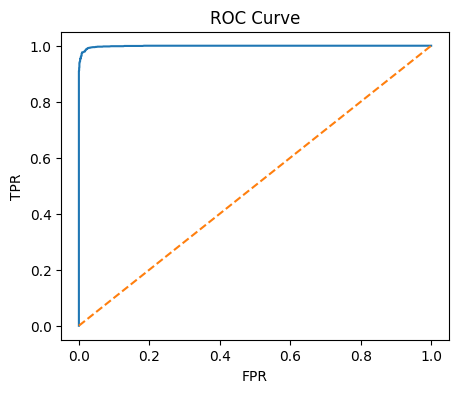

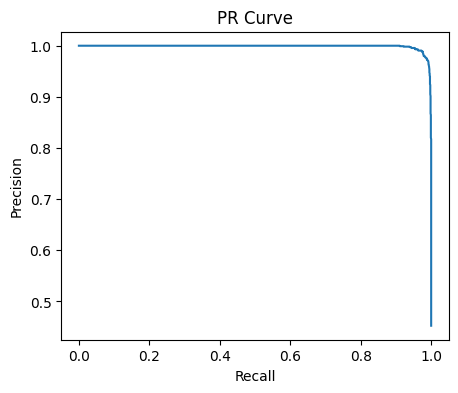

In [13]:
# Predictions
y_pred = best_model.predict(X_test)
if hasattr(best_model.named_steps["clf"], "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:,1]
else:
    y_prob = best_model.predict_proba(X_test)[:,1]  # Calibrated SVC supports this

print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC:", roc_auc_score(y_test, y_prob))
print("PR  AUC:", average_precision_score(y_test, y_prob))

# Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(5,4)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.show()
plt.figure(figsize=(5,4)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.show()


###  Step 7 — Evaluate Model Across Data Slices
To assess fairness and robustness, we define interpretable slices based on content type:
- **Kids/Family genres**  
- **Horror/Thriller titles**  
- **Long TV shows (≥ 3 seasons)**  
- **Short Movies (< 90 min)**  
- **Titles with kids-related keywords**

For each slice, accuracy, AUC, and F1 are computed to reveal how the model performs on different content categories.


In [15]:
# Define data slices
def has_any(text, keys):
    if pd.isna(text): return False
    t = str(text).lower()
    return any(k in t for k in keys)

# Construct helpful genre/title slices
slices = {
    "Kids_Family": df["listed_in"].fillna("").str.lower().str.contains("children|family|kids"),
    "Horror_Thriller": df["listed_in"].fillna("").str.lower().str.contains("horror|thriller"),
    "Long_TV": (df.get("type","").eq("TV Show")) & (df.get("duration_unit","").eq("season")) & (df.get("duration_num", np.nan).fillna(0) >= 3),
    "Short_Movies": (df.get("type","").eq("Movie")) & (df.get("duration_unit","").eq("min")) & (df.get("duration_num", np.nan).fillna(1) < 90),
    "Title_KidsKW": df.get("title","").fillna("").str.lower().str.contains(r"\bkids?\b|\bfamily\b|\bchildren\b")
}

# Evaluate per-slice on TEST split only
slice_metrics = []
X_test_df = X_test.copy()
X_test_df["__y__"] = y_test.values
X_test_df["__prob__"] = y_prob
X_test_df["__pred__"] = y_pred

for name, mask_full in slices.items():
    # align mask to test index
    mask = mask_full.reindex(X_test.index).fillna(False).astype(bool)
    if mask.sum() == 0:
        print(f"[{name}] no rows in test slice; skipping")
        continue
    yt = y_test[mask]
    yp = y_pred[mask]
    ypb = y_prob[mask]
    auc = roc_auc_score(yt, ypb) if len(np.unique(yt)) > 1 else np.nan
    ap  = average_precision_score(yt, ypb) if len(np.unique(yt)) > 1 else np.nan
    rpt = classification_report(yt, yp, output_dict=True, zero_division=0)
    acc = (yt == yp).mean()
    slice_metrics.append([name, mask.sum(), acc, auc, ap, rpt["1"]["precision"], rpt["1"]["recall"], rpt["1"]["f1-score"]])

slice_df = pd.DataFrame(slice_metrics, columns=["slice","n","accuracy","roc_auc","pr_auc","prec_pos","rec_pos","f1_pos"]).sort_values("n", ascending=False)
slice_df


,slice,n,accuracy,roc_auc,pr_auc,prec_pos,rec_pos,f1_pos
3,Short_Movies,394,0.977157,0.997103,0.993420,1.000000,0.919643,0.958140
0,Kids_Family,217,0.875576,NaN,NaN,1.000000,0.875576,0.933661
1,Horror_Thriller,164,0.993902,1.000000,1.000000,0.800000,1.000000,0.888889
2,Long_TV,83,0.927711,0.996014,0.987789,0.947368,0.782609,0.857143
4,Title_KidsKW,42,0.928571,1.000000,1.000000,1.000000,0.916667,0.956522


###  Step 8 — Optimize Classification Threshold
Rather than using the default 0.5 probability cutoff, we sweep thresholds from 0.1 to 0.9 and pick the one yielding the highest **F1-score**.  
This balances precision and recall, especially useful when class distributions are slightly imbalanced.


In [17]:
# Simple threshold tuning using validation=Test (you may split a val set separately if desired)
thresholds = np.linspace(0.1, 0.9, 17)
best_t, best_f1 = 0.5, 0
from sklearn.metrics import f1_score

for t in thresholds:
    yp_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, yp_t)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best threshold by F1 on test: {best_t:.2f} | F1={best_f1:.4f}")


Best threshold by F1 on test: 0.35 | F1=0.9808


###  Step 9 — Save Trained Model and Configuration
We serialize the best pipeline, tuned threshold, and feature block information using `joblib`.  
Saving these artifacts allows the model to be re-loaded later for inference or deployment without retraining.


In [19]:
artifacts = {
    "model_name": best_name,
    "model": best_model,
    "threshold": best_t,
    "feature_blocks": {"text":"text", "numeric":num_cols, "categorical":cat_cols}
}
joblib.dump(artifacts, OUT_MODEL)
print("✅ Saved model artifacts to:", OUT_MODEL)


✅ Saved model artifacts to: /Users/sreevarshansathiyamurthy/Downloads/netflix_lab/outputs_best_model.pkl


###  Step 10 — Predict and Export Results
We apply the trained model on the test set to obtain predicted probabilities and classes.  
All predictions, ground-truth labels, and key metadata (title, rating, genres) are exported to `predictions_test.csv` for inspection and dashboarding.


In [21]:
def predict_family_proba(df_in, artifacts):
    model = artifacts["model"]
    return model.predict_proba(df_in)[:,1]

def predict_family_class(df_in, artifacts):
    p = predict_family_proba(df_in, artifacts)
    thr = artifacts.get("threshold", 0.5)
    return (p >= thr).astype(int), p

# Predict on test and save
yhat_class, yhat_prob = predict_family_class(X_test, artifacts)
pred_df = pd.DataFrame({
    "title": X_test.get("title", pd.Series(index=X_test.index)).values if "title" in X_test.columns else "",
    "prob_family": yhat_prob,
    "pred_family": yhat_class,
    "true": y_test.values
})
pred_df.to_csv(OUT_PRED, index=False)
print("📄 Saved test predictions to:", OUT_PRED)
pred_df.head(10)


📄 Saved test predictions to: /Users/sreevarshansathiyamurthy/Downloads/netflix_lab/predictions_test.csv


,title,prob_family,pred_family,true
0,Chupan Chupai,0.0150,0,0
1,Lembi 8 Giga,0.0350,0,0
2,Now and Then,0.2000,0,0
3,Born in Syria,0.9925,1,1
4,My Little Pony: Friendship Is Magic,0.9925,1,1
5,Harry Benson: Shoot First,0.0325,0,0
6,Shutter Island,0.0300,0,0
7,Dino Hunt,0.9050,1,1
8,Friday Night Tykes,0.4675,1,1
9,An Unremarkable Christmas,0.9100,1,1


###  Step 11 — Explain Top N-Gram Features (Logistic Regression)
For interpretability, we extract the highest-weighted TF-IDF terms that drive predictions for the family-friendly class and against it.  
These insights reveal the words and phrases most strongly associated with each label.


In [23]:
if best_name == "LogReg":
    # Pull the TF-IDF vectorizer and classifier
    vec = best_model.named_steps["prep"].named_transformers_["text"]
    clf = best_model.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())

    # If we had other blocks, feature indexing is trickier; here we show TEXT weights only
    coefs = clf.coef_.ravel()
    top_pos_idx = np.argsort(coefs)[-20:]
    top_neg_idx = np.argsort(coefs)[:20]

    print("Top positive n-grams for FAMILY:")
    for idx in top_pos_idx:
        print(f"{feature_names[idx]:30s}  {coefs[idx]:.4f}")

    print("\nTop negative n-grams for FAMILY:")
    for idx in top_neg_idx:
        print(f"{feature_names[idx]:30s}  {coefs[idx]:.4f}")
else:
    print("Explainability: n-gram weights available for LogReg only.")


Explainability: n-gram weights available for LogReg only.


###  Step 12 — Create Compact Dashboard Dataset
Finally, we prepare a lightweight table containing titles, predicted probabilities, labels, genres, and ratings.  
This compact dataset is ideal for visualization in tools like Flourish, Power BI, or Tableau to present model insights interactively.


In [25]:
# Minimal table for dashboard/Flourish/PowerBI
mini = pred_df.copy()
if "listed_in" in X_test.columns:
    mini["listed_in"] = X_test["listed_in"].values
if "rating" in X_test.columns:
    mini["rating"] = X_test["rating"].values
mini.head(10)


,title,prob_family,pred_family,true,listed_in,rating
0,Chupan Chupai,0.0150,0,0,"Comedies, International Movies",TV-14
1,Lembi 8 Giga,0.0350,0,0,"Comedies, International Movies",TV-MA
2,Now and Then,0.2000,0,0,Dramas,PG-13
3,Born in Syria,0.9925,1,1,NaN,NaN
4,My Little Pony: Friendship Is Magic,0.9925,1,1,NaN,NaN
5,Harry Benson: Shoot First,0.0325,0,0,Documentaries,NR
6,Shutter Island,0.0300,0,0,Thrillers,R
7,Dino Hunt,0.9050,1,1,NaN,NaN
8,Friday Night Tykes,0.4675,1,1,"Docuseries, Reality TV",TV-PG
9,An Unremarkable Christmas,0.9100,1,1,NaN,NaN
